In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

In [2]:
method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial Parameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure Competency", 
                           "real_early": "Real early Param.",
                           "real_parameters": "Real Param."}


def parameter_table_model(df, latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    rmse_columns = ["method", "sample_size", "rmse_early_A", "rmse_early_delta", "rmse_early_sigma",
                    "rmse_late_A", "rmse_late_delta", "rmse_late_sigma", "rmse_psi"]
    sub_df = sub_df[rmse_columns]
    columns = ["Method","Sample size", "$A^e$", "$\Delta^e$", "$\Sigma^e$",
                       "$A^l$", "$\Delta^l$", "$\Sigma^l$", "$\Psi$"]
    sub_df.columns = columns
    sub_df = sub_df.replace(method_replacement_dict)
    parameter_table = sub_df.groupby(["Sample size", "Method"]).agg(aggfunc)
    parameter_table = np.round(parameter_table, decimals)
    #parameter_table.columns = pd.MultiIndex.from_product([["RMSE"], parameter_table.columns], names=['Metric', ''])
    
    #columns = list(zip(["RMSE" for i in range(0, len(columns))],parameter_table.columns))
    #parameter_table.columns = columns
    print(parameter_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(parameter_table)
    

In [3]:
# Make one combined Model-fit table for all Q-Matrices
def likelihood_table_model(df_list, Q_names=["Full", "Seperated", "Pyramid"], 
                            latent_dimension=2, item_dimension=20,
                             aggfunc="median", caption="", decimals=3):
    combined_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        df = df[(df["item_dimension"] == item_dimension) & (df["latent_dimension"] == latent_dimension)]
        q_df_early = df[["early_l_estimated", "method", "sample_size"]]
        
        q_df_early.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_early.loc[:,"Model"] = "Early"
        q_df_late = df[["late_l_estimated", "method", "sample_size"]]
        q_df_late.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_late.loc[:,"Model"] = "Late"
        q_df = pd.concat((q_df_early, q_df_late), axis=0)
        q_df["Q-type"] = Q_names[i]
        combined_df = pd.concat((combined_df, q_df), axis=0)
    combined_df = combined_df.replace(method_replacement_dict)
    combined_df = np.round(combined_df, 0)
    fit_table = pd.crosstab(index=[combined_df["N"], combined_df["Method"]], 
                            columns=[combined_df["Model"], combined_df["Q-type"]],
                            values=combined_df["Marginal Log-Likelihood"],
                            aggfunc=aggfunc)
    n = np.min(combined_df.groupby(["Model", "Q-type", "N"])["Method"].value_counts())
    print(fit_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(fit_table)

# TODO: Maybe include empirical likelihood not only marginal?

In [4]:
def single_metric_table(df, metric, aggfunc="median", latex=True, decimals=3, caption=""):
    df = df.replace(method_replacement_dict)
    n = np.min(df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    table = pd.crosstab(index=[df["sample_size"], df["method"]],
                columns=[df["latent_dimension"], df["item_dimension"]], 
                values=df[metric], 
                aggfunc=aggfunc)
    table = np.round(table, decimals)
    if latex:
        print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,
                             caption=caption+", n={0}".format(n),
                             position="H"))
    return(table)

In [5]:
def model_boxplot(df, metric='rmse_psi', latent_dimension=2, item_dimension=20, 
                  title="",
                  methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[(sub_df["method"].isin(methods))]
    sub_df = sub_df.replace(method_replacement_dict)
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    fig = plt.gcf()
    fig.set_dpi(100)
    fig.set_size_inches(10, 5)
    plt.title(title+", n={0}".format(n))
    sn.boxplot(x=sub_df[metric], hue=sub_df["sample_size"].astype("str"), y=sub_df["method"],
               orient="h")

# Results

In [6]:
full_Q_df = pd.read_csv("results/full_q.csv")
print("Full Q sample size: {0}".format(full_Q_df.shape[0]))
sep_Q_df = pd.read_csv("results/seperated_q.csv")
print("Seperated Q sample size: {0}".format(sep_Q_df.shape[0]))
pyramid_Q_df = pd.read_csv("results/pyramid_q.csv")
print("Pyramid Q sample size: {0}".format(pyramid_Q_df.shape[0]))

Full Q sample size: 3468
Seperated Q sample size: 3306
Pyramid Q sample size: 2706


## Simulatuion Results

### Model Fit

In [7]:
single_metric_table(full_Q_df, metric="late_l_estimated")

\begin{table}[H]
\centering
\caption{, n=17}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{item\_dimension} &        10 &        20 &        30 &        10 &        20 &        30 \\
\textbf{sample\_size} & \textbf{method} &           &           &           &           &           &           \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  -183.365 &  -288.170 &  -421.015 &  -211.995 &  -315.615 &  -427.490 \\
    & \textbf{Initial Parameters} &  -232.125 &  -391.600 &  -541.505 &  -281.410 &  -457.485 &  -613.050 \\
    & \textbf{Late EM} &  -178.870 &  -288.505 &  -413.880 &  -197.670 &  -311.020 &  -429.680 \\
    & \textbf{Pure Competency} &  -181.160 &  -288.870 &  -410.995 &  -205.485 &  -309.260 &  -425.000 \\
    & \textbf{Real Param.} &  -192.425 &  -318.665 &  -457.180 &  -221.265 &  -337.945 &  -468.640 \\
    & \textbf{Real early Param.} &  -189.115 &  -295.985 &  -413

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                       2                             3  \
item_dimension                        10        20        30        10   
sample_size method                                                       
30          Difference          -183.365  -288.170  -421.015  -211.995   
            Initial Parameters  -232.125  -391.600  -541.505  -281.410   
            Late EM             -178.870  -288.505  -413.880  -197.670   
            Pure Competency     -181.160  -288.870  -410.995  -205.485   
            Real Param.         -192.425  -318.665  -457.180  -221.265   
            Real early Param.   -189.115  -295.985  -413.730  -221.405   
100         Difference          -679.595 -1065.430 -1460.675  -726.140   
            Initial Parameters  -856.425 -1324.880 -1848.075  -933.870   
            Late EM             -654.265 -1032.720 -1449.450  -708.950   
            Pure Competency     -658.875 -1056.000 -1442.530  -729.270   
            Real Param.         -693.575 -1074.010 -1473.105  -746.580   
            Real early Param.   -669.705 -1045.060 -1452.510  -767.260   
200         Difference         -1292.195 -2070.075 -3059.000 -1501.520   
            Initial Parameters -1567.835 -2619.175 -3788.510 -1980.180   
            Late EM            -1254.380 -2014.475 -2986.710 -1431.200   
            Pure Competency    -1276.565 -2022.090 -2997.170 -1493.970   
            Real Param.        -1335.235 -2108.615 -3087.660 -1521.025   
            Real early Param.  -1326.135 -2016.895 -2974.940 -1581.755   

latent_dimension                                    
item_dimension                        20        30  
sample_size method                                  
30          Difference          -315.615  -427.490  
            Initial Parameters  -457.485  -613.050  
            Late EM             -311.020  -429.680  
            Pure Competency     -309.260  -425.000  
            Real Param.         -337.945  -468.640  
            Real early Param.   -314.025  -429.390  
100         Difference         -1102.180 -1503.770  
            Initial Parameters -1568.640 -2043.845  
            Late EM            -1101.000 -1499.195  
            Pure Competency    -1090.420 -1514.560  
            Real Param.        -1146.910 -1534.645  
            Real early Param.  -1127.590 -1524.340  
200         Difference         -2259.440 -3157.920  
            Initial Parameters -3093.890 -4688.260  
            Late EM            -2176.850 -3106.550  
            Pure Competency    -2196.700 -3103.890  
            Real Param.        -2271.350 -3204.860  
            Real early Param.  -2260.960 -3081.320

In [8]:
likelihood_table_model(df_list=[full_Q_df, sep_Q_df, pyramid_Q_df], caption="Marginal Log-Likelihood, $D=2$, $J=20$")

\begin{table}[H]
\centering
\caption{Marginal Log-Likelihood, $D=2$, $J=20$, n=31}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Model} & \multicolumn{3}{l}{Early} & \multicolumn{3}{l}{Late} \\
    & \textbf{Q-type} &    Full & Pyramid & Seperated &    Full & Pyramid & Seperated \\
\textbf{N} & \textbf{Method} &         &         &           &         &         &           \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  -283.0 &  -276.0 &    -311.0 &  -288.0 &  -285.5 &    -318.5 \\
    & \textbf{Initial Parameters} &  -313.0 &  -305.0 &    -330.5 &  -391.5 &  -356.5 &    -423.5 \\
    & \textbf{Late EM} &  -283.0 &  -276.5 &    -311.0 &  -288.5 &  -288.5 &    -313.5 \\
    & \textbf{Pure Competency} &  -284.0 &  -276.5 &    -311.0 &  -289.0 &  -282.5 &    -314.5 \\
    & \textbf{Real Param.} &  -315.0 &  -308.0 &    -336.0 &  -319.0 &  -315.5 &    -333.0 \\
    & \textbf{Real early Param.} &     NaN &     NaN &       NaN &  -296.0 &  -289.0 &    -321.5 \\
\cline{

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\3349180261.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fit_table.to_latex(bold_rows=True, multirow=True,


Model                    Early                      Late                  
Q-type                    Full Pyramid Seperated    Full Pyramid Seperated
N   Method                                                                
30  Difference          -283.0  -276.0    -311.0  -288.0  -285.5    -318.5
    Initial Parameters  -313.0  -305.0    -330.5  -391.5  -356.5    -423.5
    Late EM             -283.0  -276.5    -311.0  -288.5  -288.5    -313.5
    Pure Competency     -284.0  -276.5    -311.0  -289.0  -282.5    -314.5
    Real Param.         -315.0  -308.0    -336.0  -319.0  -315.5    -333.0
    Real early Param.      NaN     NaN       NaN  -296.0  -289.0    -321.5
100 Difference          -998.0 -1001.0   -1082.0 -1065.0 -1031.0   -1128.0
    Initial Parameters -1058.0 -1042.0   -1119.0 -1325.0 -1252.0   -1447.0
    Late EM             -997.0 -1001.0   -1083.0 -1033.0  -999.0   -1119.0
    Pure Competency    -1008.0 -1002.0   -1086.0 -1056.0 -1029.0   -1107.0
    Real Param.        -1053.0 -1025.5   -1126.5 -1074.0 -1052.0   -1154.0
    Real early Param.      NaN     NaN       NaN -1045.0 -1036.0   -1116.0
200 Difference         -2055.5 -1983.0   -2188.0 -2070.0 -1993.0   -2342.5
    Initial Parameters -2138.0 -2071.0   -2264.5 -2619.5 -2352.0   -3046.0
    Late EM            -2055.5 -1983.0   -2186.5 -2014.5 -1956.0   -2299.0
    Pure Competency    -2056.5 -1983.0   -2197.5 -2022.0 -2008.0   -2288.0
    Real Param.        -2155.5 -1996.0   -2221.0 -2108.5 -2055.0   -2354.5
    Real early Param.      NaN     NaN       NaN -2017.0 -2055.0   -2327.0

### Full Q Matrix

In [9]:
parameter_table_model(full_Q_df, caption="Full Q-Matrix, Reference Model")

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


\begin{table}[H]
\centering
\caption{Full Q-Matrix, Reference Model, n=38}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  1.603 &       1.300 &       0.066 &  2.772 &       2.878 &       0.220 &   0.262 \\
    & \textbf{Initial Parameters} &  0.615 &       0.557 &       0.178 &  0.876 &       1.566 &       0.419 &   0.370 \\
    & \textbf{Late EM} &  1.554 &       1.314 &       0.065 &  4.610 &       4.315 &       0.229 &   0.317 \\
    & \textbf{Pure Competency} &  1.624 &       1.274 &       0.175 &  4.798 &       3.874 &       0.242 &   0.303 \\
    & \textbf{Real Param.} &  0.000 &       0.000 &       0.000 &  0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} &    NaN

$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.603       1.300       0.066  2.772   
            Initial Parameters  0.615       0.557       0.178  0.876   
            Late EM             1.554       1.314       0.065  4.610   
            Pure Competency     1.624       1.274       0.175  4.798   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  4.089   
100         Difference          0.482       0.399       0.066  0.577   
            Initial Parameters  0.673       0.442       0.178  0.879   
            Late EM             0.449       0.394       0.065  0.767   
            Pure Competency     0.477       0.392       0.175  0.792   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  0.675   
200         Difference          0.339       0.251       0.070  0.438   
            Initial Parameters  0.686       0.401       0.184  0.927   
            Late EM             0.337       0.249       0.081  0.502   
            Pure Competency     0.332       0.258       0.170  0.470   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  0.472   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.878       0.220   0.262  
            Initial Parameters       1.566       0.419   0.370  
            Late EM                  4.315       0.229   0.317  
            Pure Competency          3.874       0.242   0.303  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        3.567       0.175   0.327  
100         Difference               0.709       0.146   0.217  
            Initial Parameters       1.416       0.439   0.361  
            Late EM                  0.780       0.186   0.285  
            Pure Competency          1.046       0.289   0.284  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.734       0.181   0.272  
200         Difference               0.513       0.112   0.212  
            Initial Parameters       1.555       0.381   0.334  
            Late EM                  0.664       0.198   0.290  
            Pure Competency          0.719       0.275   0.260  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.568       0.156   0.289

In [10]:
single_metric_table(full_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=17}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.318 &  0.262 &  0.260 &  0.328 &  0.287 &  0.273 \\
    & \textbf{Initial Parameters} &  0.337 &  0.370 &  0.296 &  0.315 &  0.324 &  0.328 \\
    & \textbf{Late EM} &  0.286 &  0.317 &  0.280 &  0.305 &  0.333 &  0.337 \\
    & \textbf{Pure Competency} &  0.257 &  0.303 &  0.260 &  0.276 &  0.283 &  0.300 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.306 &  0.327 &  0.285 &  0.317 &  0.367 &  0.360 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.269

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2                    3              
item_dimension                     10     20     30     10     20     30
sample_size method                                                      
30          Difference          0.318  0.262  0.260  0.328  0.287  0.273
            Initial Parameters  0.337  0.370  0.296  0.315  0.324  0.328
            Late EM             0.286  0.317  0.280  0.305  0.333  0.337
            Pure Competency     0.257  0.303  0.260  0.276  0.283  0.300
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.306  0.327  0.285  0.317  0.367  0.360
100         Difference          0.269  0.217  0.155  0.289  0.226  0.223
            Initial Parameters  0.354  0.361  0.368  0.322  0.313  0.333
            Late EM             0.298  0.285  0.330  0.304  0.310  0.322
            Pure Competency     0.307  0.284  0.244  0.289  0.284  0.285
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.275  0.272  0.325  0.324  0.327  0.347
200         Difference          0.270  0.212  0.190  0.277  0.239  0.199
            Initial Parameters  0.371  0.334  0.389  0.312  0.331  0.366
            Late EM             0.315  0.290  0.347  0.311  0.332  0.378
            Pure Competency     0.288  0.260  0.297  0.291  0.290  0.317
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.318  0.289  0.339  0.310  0.348  0.369

In [11]:
single_metric_table(full_Q_df, "rmse_late_sigma", caption="RMSE for Correlations late sigma")

\begin{table}[H]
\centering
\caption{RMSE for Correlations late sigma, n=17}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.208 &  0.220 &  0.260 &  0.257 &  0.230 &  0.233 \\
    & \textbf{Initial Parameters} &  0.385 &  0.419 &  0.470 &  0.408 &  0.419 &  0.463 \\
    & \textbf{Late EM} &  0.276 &  0.229 &  0.234 &  0.259 &  0.236 &  0.209 \\
    & \textbf{Pure Competency} &  0.243 &  0.242 &  0.284 &  0.295 &  0.281 &  0.306 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.230 &  0.175 &  0.210 &  0.238 &  0.215 &  0.190 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2                    3              
item_dimension                     10     20     30     10     20     30
sample_size method                                                      
30          Difference          0.208  0.220  0.260  0.257  0.230  0.233
            Initial Parameters  0.385  0.419  0.470  0.408  0.419  0.463
            Late EM             0.276  0.229  0.234  0.259  0.236  0.209
            Pure Competency     0.243  0.242  0.284  0.295  0.281  0.306
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.230  0.175  0.210  0.238  0.215  0.190
100         Difference          0.156  0.146  0.183  0.210  0.166  0.202
            Initial Parameters  0.353  0.439  0.313  0.372  0.345  0.429
            Late EM             0.211  0.186  0.172  0.269  0.259  0.256
            Pure Competency     0.219  0.289  0.239  0.300  0.294  0.335
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.145  0.181  0.144  0.216  0.213  0.251
200         Difference          0.156  0.112  0.145  0.216  0.149  0.126
            Initial Parameters  0.379  0.381  0.371  0.387  0.389  0.431
            Late EM             0.242  0.198  0.184  0.295  0.229  0.244
            Pure Competency     0.259  0.275  0.225  0.341  0.279  0.298
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.172  0.156  0.154  0.241  0.209  0.226

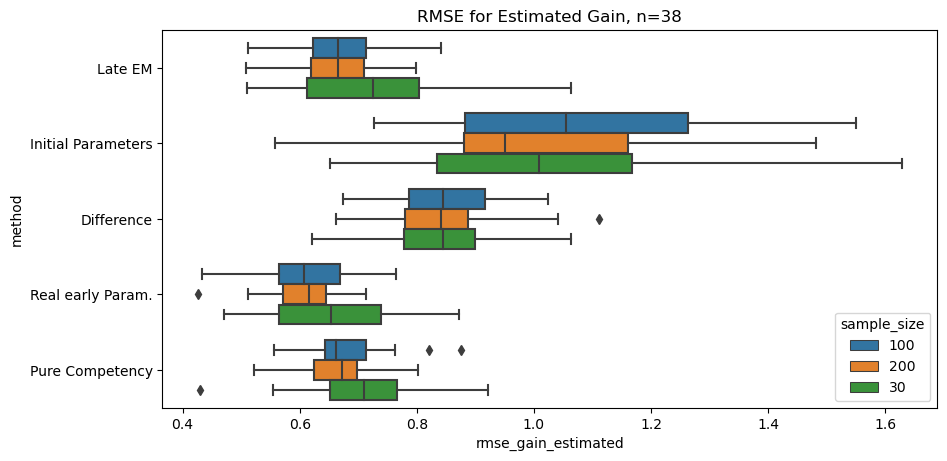

In [12]:
model_boxplot(full_Q_df, metric='rmse_gain_estimated', title="RMSE for Estimated Gain")

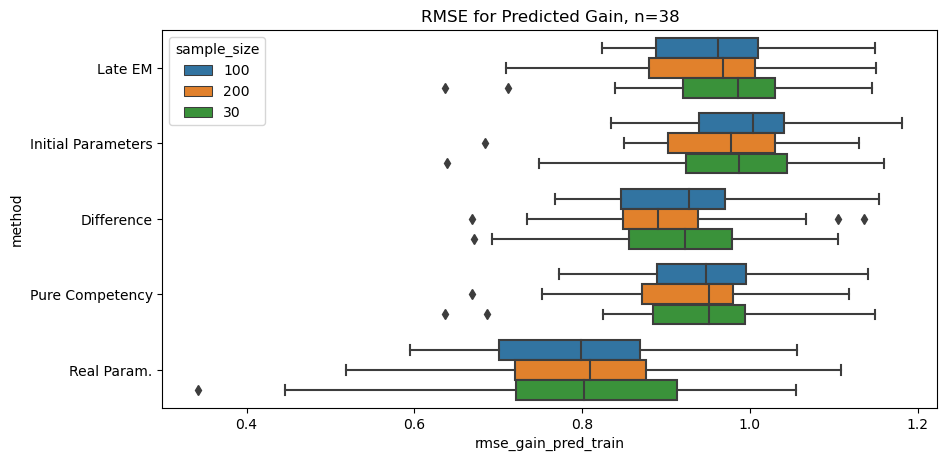

In [13]:
model_boxplot(full_Q_df, metric='rmse_gain_pred_train', title="RMSE for Predicted Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency"])

### Seperated Q-Matrix

In [14]:
parameter_table_model(sep_Q_df, caption="Seperated Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix, Reference Model, n=36}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.903 &       0.915 &       0.087 &  1.469 &       1.735 &       0.190 &   0.252 \\
    & \textbf{Initial Parameters} &  0.517 &       0.512 &       0.176 &  0.904 &       1.303 &       0.453 &   0.347 \\
    & \textbf{Late EM} &  0.879 &       0.897 &       0.071 &  2.039 &       1.491 &       0.167 &   0.357 \\
    & \textbf{Pure Competency} &  0.945 &       0.888 &       0.178 &  2.184 &       2.036 &       0.259 &   0.281 \\
    & \textbf{Real Param.} &  0.000 &       0.000 &       0.000 &  0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} &  

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          0.903       0.915       0.087  1.469   
            Initial Parameters  0.517       0.512       0.176  0.904   
            Late EM             0.879       0.897       0.071  2.039   
            Pure Competency     0.945       0.888       0.178  2.184   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  1.909   
100         Difference          0.355       0.385       0.056  0.370   
            Initial Parameters  0.474       0.370       0.113  0.883   
            Late EM             0.337       0.390       0.056  0.413   
            Pure Competency     0.344       0.381       0.242  0.402   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  0.385   
200         Difference          0.245       0.232       0.043  0.275   
            Initial Parameters  0.569       0.342       0.162  0.881   
            Late EM             0.237       0.224       0.045  0.289   
            Pure Competency     0.249       0.225       0.192  0.283   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  0.290   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               1.735       0.190   0.252  
            Initial Parameters       1.303       0.453   0.347  
            Late EM                  1.491       0.167   0.357  
            Pure Competency          2.036       0.259   0.281  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        1.921       0.161   0.374  
100         Difference               0.566       0.132   0.203  
            Initial Parameters       1.326       0.363   0.358  
            Late EM                  0.729       0.198   0.340  
            Pure Competency          0.909       0.232   0.272  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.655       0.179   0.326  
200         Difference               0.305       0.138   0.220  
            Initial Parameters       1.239       0.349   0.340  
            Late EM                  0.764       0.192   0.302  
            Pure Competency          0.715       0.214   0.303  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.552       0.164   0.305

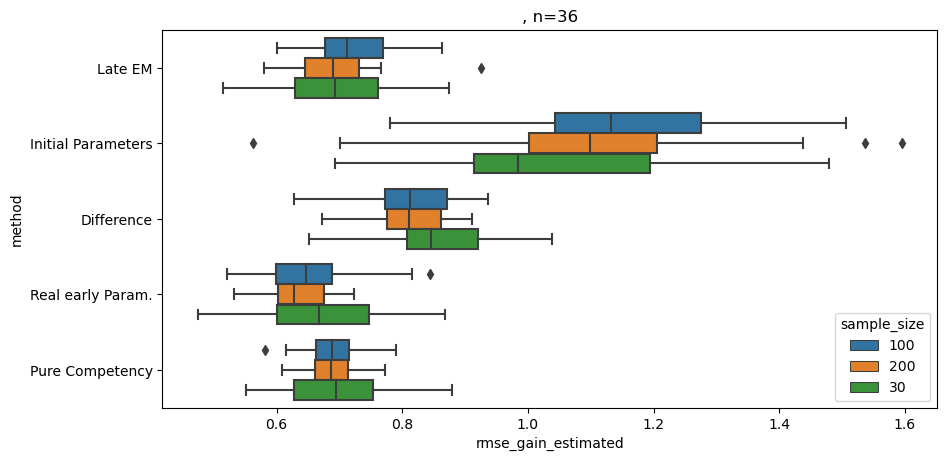

In [15]:
model_boxplot(sep_Q_df, metric='rmse_gain_estimated')

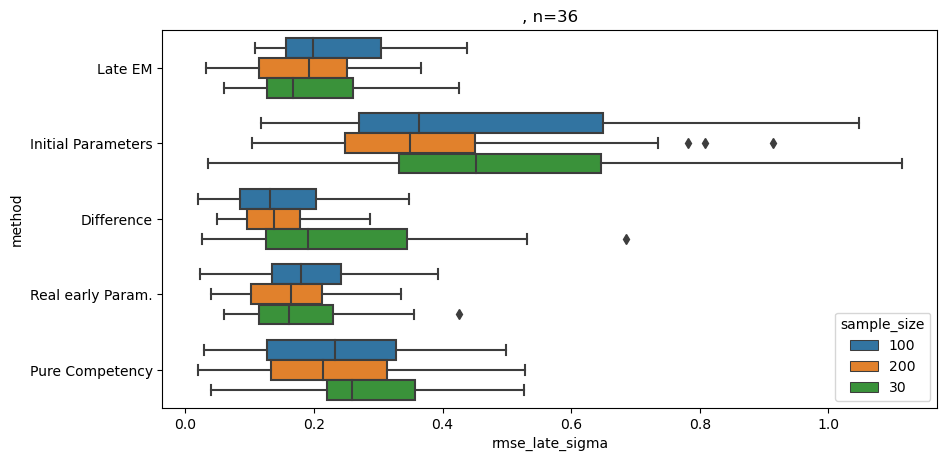

In [16]:
model_boxplot(sep_Q_df, metric='rmse_late_sigma')

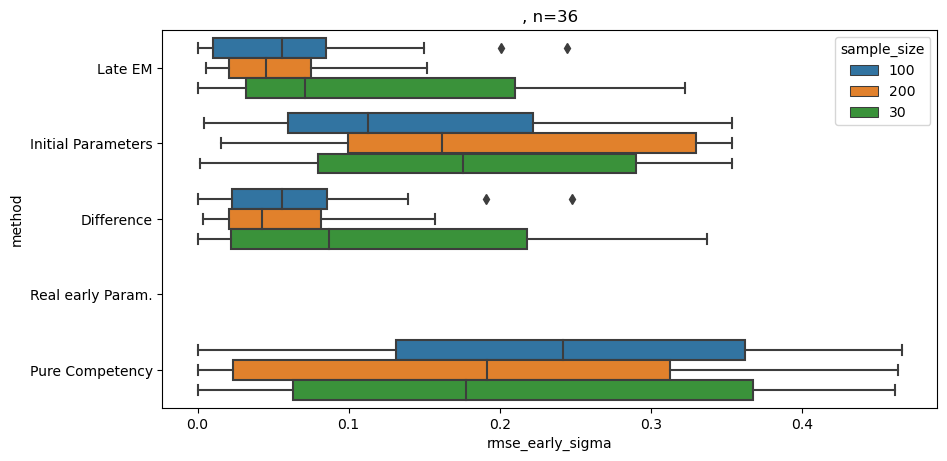

In [17]:
model_boxplot(sep_Q_df, metric='rmse_early_sigma')

### Pyramid Q-Matrix

In [18]:
parameter_table_model(full_Q_df, caption="Pyramid-Q-Matrix, RMSE Median of Parameter Recovery")

\begin{table}[H]
\centering
\caption{Pyramid-Q-Matrix, RMSE Median of Parameter Recovery, n=38}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  1.603 &       1.300 &       0.066 &  2.772 &       2.878 &       0.220 &   0.262 \\
    & \textbf{Initial Parameters} &  0.615 &       0.557 &       0.178 &  0.876 &       1.566 &       0.419 &   0.370 \\
    & \textbf{Late EM} &  1.554 &       1.314 &       0.065 &  4.610 &       4.315 &       0.229 &   0.317 \\
    & \textbf{Pure Competency} &  1.624 &       1.274 &       0.175 &  4.798 &       3.874 &       0.242 &   0.303 \\
    & \textbf{Real Param.} &  0.000 &       0.000 &       0.000 &  0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real e

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.603       1.300       0.066  2.772   
            Initial Parameters  0.615       0.557       0.178  0.876   
            Late EM             1.554       1.314       0.065  4.610   
            Pure Competency     1.624       1.274       0.175  4.798   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  4.089   
100         Difference          0.482       0.399       0.066  0.577   
            Initial Parameters  0.673       0.442       0.178  0.879   
            Late EM             0.449       0.394       0.065  0.767   
            Pure Competency     0.477       0.392       0.175  0.792   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  0.675   
200         Difference          0.339       0.251       0.070  0.438   
            Initial Parameters  0.686       0.401       0.184  0.927   
            Late EM             0.337       0.249       0.081  0.502   
            Pure Competency     0.332       0.258       0.170  0.470   
            Real Param.         0.000       0.000       0.000  0.000   
            Real early Param.     NaN         NaN         NaN  0.472   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.878       0.220   0.262  
            Initial Parameters       1.566       0.419   0.370  
            Late EM                  4.315       0.229   0.317  
            Pure Competency          3.874       0.242   0.303  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        3.567       0.175   0.327  
100         Difference               0.709       0.146   0.217  
            Initial Parameters       1.416       0.439   0.361  
            Late EM                  0.780       0.186   0.285  
            Pure Competency          1.046       0.289   0.284  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.734       0.181   0.272  
200         Difference               0.513       0.112   0.212  
            Initial Parameters       1.555       0.381   0.334  
            Late EM                  0.664       0.198   0.290  
            Pure Competency          0.719       0.275   0.260  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.568       0.156   0.289

In [19]:
single_metric_table(pyramid_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=9}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.310 &  0.305 &  0.230 &  0.325 &  0.340 &  0.327 \\
    & \textbf{Initial Parameters} &  0.354 &  0.370 &  0.340 &  0.289 &  0.338 &  0.368 \\
    & \textbf{Late EM} &  0.310 &  0.277 &  0.302 &  0.297 &  0.342 &  0.285 \\
    & \textbf{Pure Competency} &  0.280 &  0.290 &  0.223 &  0.253 &  0.304 &  0.306 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.305 &  0.300 &  0.306 &  0.316 &  0.389 &  0.302 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.294 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2                    3              
item_dimension                     10     20     30     10     20     30
sample_size method                                                      
30          Difference          0.310  0.305  0.230  0.325  0.340  0.327
            Initial Parameters  0.354  0.370  0.340  0.289  0.338  0.368
            Late EM             0.310  0.277  0.302  0.297  0.342  0.285
            Pure Competency     0.280  0.290  0.223  0.253  0.304  0.306
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.305  0.300  0.306  0.316  0.389  0.302
100         Difference          0.294  0.215  0.225  0.318  0.285  0.264
            Initial Parameters  0.345  0.308  0.279  0.315  0.330  0.260
            Late EM             0.273  0.298  0.287  0.285  0.305  0.284
            Pure Competency     0.241  0.277  0.247  0.283  0.306  0.246
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.297  0.288  0.327  0.326  0.298  0.274
200         Difference          0.326  0.269  0.214  0.283  0.276  0.263
            Initial Parameters  0.355  0.285  0.326  0.293  0.346  0.321
            Late EM             0.311  0.266  0.215  0.286  0.314  0.317
            Pure Competency     0.287  0.238  0.264  0.260  0.298  0.289
            Real Param.         0.000  0.000  0.000  0.000  0.000  0.000
            Real early Param.   0.380  0.300  0.211  0.333  0.339  0.350

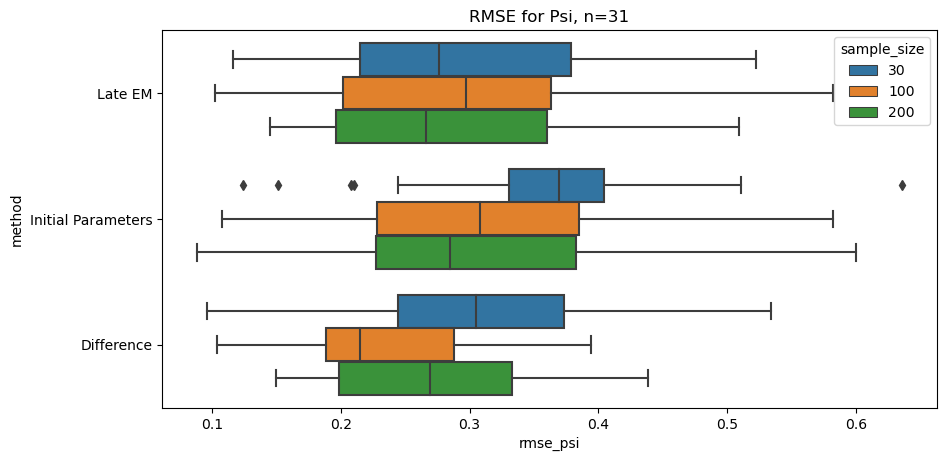

In [20]:
model_boxplot(pyramid_Q_df, metric="rmse_psi", methods=["late_em", "initial", "difference"], title="RMSE for Psi")

## Experiment 2: Prediction of Competency Gain

In [21]:
single_metric_table(full_Q_df, "rmse_theta", caption="Median RMSE for the estimation of $\\theta$")

\begin{table}[H]
\centering
\caption{Median RMSE for the estimation of $\theta$, n=17}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.613 &  0.507 &  0.458 &  0.689 &  0.579 &  0.559 \\
    & \textbf{Initial Parameters} &  0.587 &  0.515 &  0.454 &  0.673 &  0.571 &  0.538 \\
    & \textbf{Late EM} &  0.610 &  0.511 &  0.468 &  0.691 &  0.574 &  0.562 \\
    & \textbf{Pure Competency} &  0.637 &  0.503 &  0.484 &  0.698 &  0.589 &  0.570 \\
    & \textbf{Real Param.} &  0.543 &  0.459 &  0.410 &  0.612 &  0.498 &  0.474 \\
    & \textbf{Real early Param.} &  0.000 &  0.000 &  0.000 &  0.000 &  0.000 &  0.000 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Differ

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2                    3              
item_dimension                     10     20     30     10     20     30
sample_size method                                                      
30          Difference          0.613  0.507  0.458  0.689  0.579  0.559
            Initial Parameters  0.587  0.515  0.454  0.673  0.571  0.538
            Late EM             0.610  0.511  0.468  0.691  0.574  0.562
            Pure Competency     0.637  0.503  0.484  0.698  0.589  0.570
            Real Param.         0.543  0.459  0.410  0.612  0.498  0.474
            Real early Param.   0.000  0.000  0.000  0.000  0.000  0.000
100         Difference          0.596  0.488  0.426  0.639  0.545  0.488
            Initial Parameters  0.613  0.509  0.462  0.659  0.566  0.524
            Late EM             0.594  0.487  0.423  0.642  0.543  0.488
            Pure Competency     0.602  0.493  0.423  0.658  0.564  0.514
            Real Param.         0.571  0.471  0.405  0.619  0.517  0.471
            Real early Param.   0.000  0.000  0.000  0.000  0.000  0.000
200         Difference          0.580  0.465  0.416  0.642  0.533  0.481
            Initial Parameters  0.591  0.507  0.441  0.656  0.563  0.510
            Late EM             0.586  0.462  0.419  0.644  0.532  0.476
            Pure Competency     0.593  0.477  0.425  0.659  0.543  0.486
            Real Param.         0.570  0.457  0.408  0.624  0.517  0.464
            Real early Param.   0.000  0.000  0.000  0.000  0.000  0.000

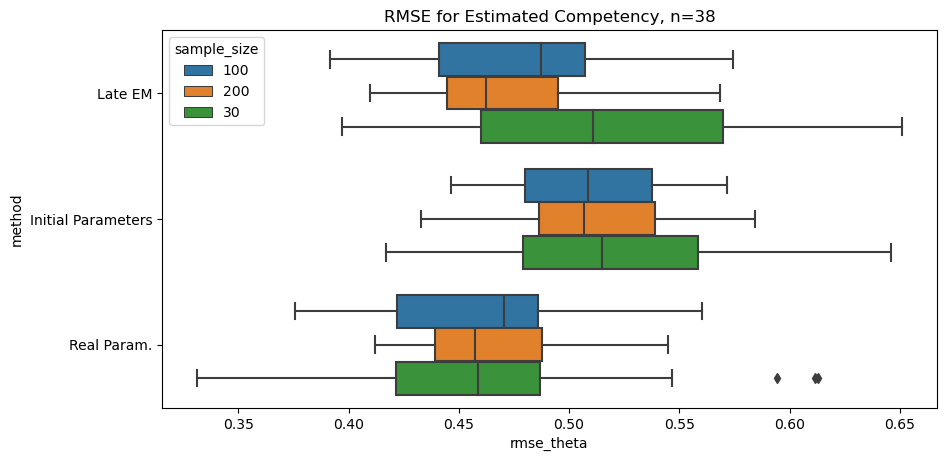

In [22]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial", "real_parameters"], title="RMSE for Estimated Competency")
plt.savefig("results/plots/boxplot_full_Q_rmse_theta.png", bbox_inches="tight")

In [23]:
single_metric_table(full_Q_df, "rmse_gain_estimated", caption="Median RMSE for Competency Gain Estimation")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Estimation, n=17}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.861 &  0.844 &  0.871 &  0.961 &  0.976 &  1.014 \\
    & \textbf{Initial Parameters} &  0.934 &  1.008 &  1.073 &  1.005 &  1.088 &  1.235 \\
    & \textbf{Late EM} &  0.765 &  0.724 &  0.633 &  0.854 &  0.761 &  0.718 \\
    & \textbf{Pure Competency} &  0.753 &  0.711 &  0.665 &  0.836 &  0.767 &  0.751 \\
    & \textbf{Real Param.} &  0.553 &  0.476 &  0.416 &  0.623 &  0.517 &  0.491 \\
    & \textbf{Real early Param.} &  0.740 &  0.654 &  0.559 &  0.815 &  0.718 &  0.685 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Differ

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2                    3              
item_dimension                     10     20     30     10     20     30
sample_size method                                                      
30          Difference          0.861  0.844  0.871  0.961  0.976  1.014
            Initial Parameters  0.934  1.008  1.073  1.005  1.088  1.235
            Late EM             0.765  0.724  0.633  0.854  0.761  0.718
            Pure Competency     0.753  0.711  0.665  0.836  0.767  0.751
            Real Param.         0.553  0.476  0.416  0.623  0.517  0.491
            Real early Param.   0.740  0.654  0.559  0.815  0.718  0.685
100         Difference          0.887  0.845  0.850  0.920  0.953  0.950
            Initial Parameters  0.898  1.055  1.065  0.997  0.993  1.223
            Late EM             0.789  0.665  0.610  0.833  0.762  0.709
            Pure Competency     0.777  0.661  0.599  0.820  0.740  0.710
            Real Param.         0.559  0.478  0.433  0.605  0.528  0.483
            Real early Param.   0.738  0.608  0.555  0.816  0.729  0.671
200         Difference          0.863  0.842  0.884  0.930  0.930  0.940
            Initial Parameters  0.878  0.950  1.042  0.980  1.097  1.181
            Late EM             0.774  0.665  0.635  0.855  0.756  0.691
            Pure Competency     0.752  0.672  0.621  0.842  0.735  0.687
            Real Param.         0.568  0.501  0.444  0.616  0.518  0.463
            Real early Param.   0.732  0.615  0.577  0.809  0.714  0.632

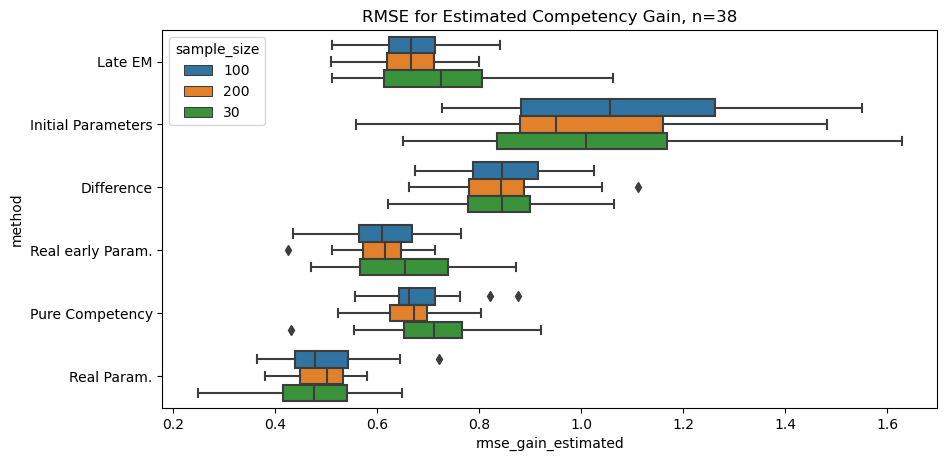

In [24]:
model_boxplot(full_Q_df, metric="rmse_gain_estimated", title="RMSE for Estimated Competency Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_estimated.png", bbox_inches="tight")

In [25]:
single_metric_table(full_Q_df, "rmse_gain_pred_train", caption="Median RMSE for Competency Gain Prediction")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Prediction, n=17}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.917 &  0.922 &  0.894 &  1.036 &  0.997 &  0.996 \\
    & \textbf{Initial Parameters} &  0.960 &  0.987 &  0.957 &  1.018 &  1.029 &  1.077 \\
    & \textbf{Late EM} &  0.953 &  0.986 &  0.984 &  1.022 &  1.053 &  1.080 \\
    & \textbf{Pure Competency} &  0.929 &  0.951 &  0.973 &  0.998 &  0.995 &  1.051 \\
    & \textbf{Real Param.} &  0.782 &  0.802 &  0.806 &  0.856 &  0.840 &  0.886 \\
    & \textbf{Real early Param.} &  0.930 &  0.966 &  0.979 &  1.018 &  1.062 &  1.068 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Differ

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2                    3              
item_dimension                     10     20     30     10     20     30
sample_size method                                                      
30          Difference          0.917  0.922  0.894  1.036  0.997  0.996
            Initial Parameters  0.960  0.987  0.957  1.018  1.029  1.077
            Late EM             0.953  0.986  0.984  1.022  1.053  1.080
            Pure Competency     0.929  0.951  0.973  0.998  0.995  1.051
            Real Param.         0.782  0.802  0.806  0.856  0.840  0.886
            Real early Param.   0.930  0.966  0.979  1.018  1.062  1.068
100         Difference          0.940  0.928  0.876  1.013  0.997  0.975
            Initial Parameters  1.000  1.004  0.968  1.033  1.053  1.065
            Late EM             0.980  0.962  0.976  1.025  1.050  1.045
            Pure Competency     0.972  0.948  0.936  1.008  1.034  1.020
            Real Param.         0.874  0.799  0.827  0.859  0.869  0.873
            Real early Param.   0.977  0.944  0.979  1.038  1.078  1.052
200         Difference          0.918  0.890  0.842  1.031  0.991  0.930
            Initial Parameters  0.972  0.978  0.966  1.054  1.045  1.051
            Late EM             0.960  0.967  0.936  1.045  1.059  1.062
            Pure Competency     0.940  0.952  0.936  1.036  1.024  1.008
            Real Param.         0.785  0.809  0.787  0.878  0.857  0.875
            Real early Param.   0.965  0.953  0.908  1.058  1.075  1.074

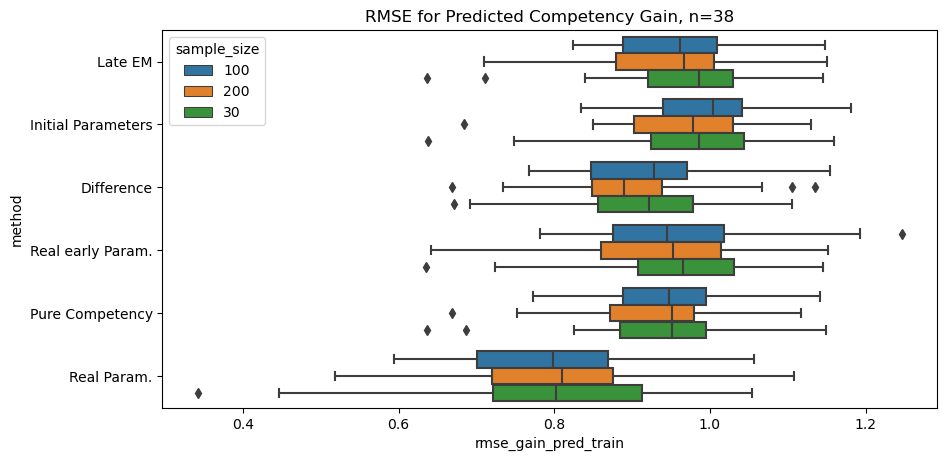

In [26]:
model_boxplot(full_Q_df, metric="rmse_gain_pred_train", title="RMSE for Predicted Competency Gain",
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_predicted.png", bbox_inches="tight")

In [27]:
np.random.exponential(scale=0.5, size=10) + 1

array([1.15715574, 1.10735343, 1.59227169, 1.09554226, 1.03523447,
       1.89723508, 1.00379382, 1.1456222 , 2.57359677, 1.01120121])

## CSEDM Data
base: uirt_lfa_model_csedm_final.ipynb

### Read in and preprocess data

In [28]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [29]:
semester = 'F19'
BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [30]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

In [31]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [32]:
V

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
363,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [34]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]
# Ensure Identification
late_Q[2,1] = False

In [35]:
late_Q

array([[False,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [False,  True]])

### Fit Model

In [36]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.3937]
 [0.3937 1.    ]]
Step: 2: current parameter_diff: 8.79484269228998, current marginal loglikelihood: -5618.534797138212
EM Iteration 3


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[0.9999 0.331 ]
 [0.331  1.    ]]
Step: 3: current parameter_diff: 4.243324757862013, current marginal loglikelihood: -5593.994900610645
EM Iteration 4
Current Monte Carlo Sample size: 349
[[1.    0.294]
 [0.294 1.   ]]
Step: 4: current parameter_diff: 3.375802512778633, current marginal loglikelihood: -5583.565487430662
EM Iteration 5
Current Monte Carlo Sample size: 376
[[1.     0.2817]
 [0.2817 1.    ]]
Step: 5: current parameter_diff: 1.5392891423017696, current marginal loglikelihood: -5583.2995762934215
EM Iteration 6
Current Monte Carlo Sample size: 406
[[1.     0.2519]
 [0.2519 1.    ]]
Step: 6: current parameter_diff: 0.8045824853604044, current marginal loglikelihood: -5580.736208623509
EM Iteration 7
Current Monte Carlo Sample size: 438
[[1.    0.242]
 [0.242 1.   ]]
Step: 7: current parameter_diff: 0.40015044945941025, current marginal loglikelihood: -5576.739643457827


In [37]:
p_early = np.mean(U, axis=1)
p_late = np.mean(V, axis=1)
# Correct numerical problems with the inverse logistic function
p_early[p_early == 0] = np.min(p_early[p_early != 0])
p_early[p_early == 1] = np.max(p_early[p_early != 1])
p_late[p_late == 0] = np.min(p_late[p_late != 0])
p_late[p_late == 1] = np.max(p_late[p_late != 1])
# get logits
logit_early = np.log(np.divide(p_early, 1 -
                                p_early))
logit_late = np.log(np.divide(p_late, 1 -
                                p_late))
var_logit_early = np.var(logit_early)
var_logit_late = np.var(logit_late)

#
print("Early logit variance: {0}".format(var_logit_early))
print("Late logit variance: {0}".format(var_logit_late))
print("Approximate convolution variance: {0}".format(var_logit_late/var_logit_early))

Early logit variance: 1.2907867467786318
Late logit variance: 1.790658381505874
Approximate convolution variance: 1.3872612079220314


In [38]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=np.zeros(2),
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.005, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2
Current Monte Carlo Sample size: 300
[[1.     0.242  0.1385 0.0616]
 [0.242  1.     0.0599 0.1388]
 [0.1385 0.0599 0.356  0.0926]
 [0.0616 0.1388 0.0926 0.3453]]
Step: 2: current parameter_diff: 12.607304296488149, current marginal loglikelihood: -4253.794464643344
EM Iteration 3


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.242  0.1412 0.0673]
 [0.242  1.     0.0626 0.1472]
 [0.1412 0.0626 0.3552 0.0885]
 [0.0673 0.1472 0.0885 0.3421]]
Step: 3: current parameter_diff: 4.859496478572539, current marginal loglikelihood: -4261.399517366359
EM Iteration 4


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[1.     0.242  0.1411 0.0659]
 [0.242  1.     0.0622 0.1463]
 [0.1411 0.0622 0.3566 0.0891]
 [0.0659 0.1463 0.0891 0.3438]]
Step: 4: current parameter_diff: 4.176294418961013, current marginal loglikelihood: -4248.427658085381
EM Iteration 5


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[1.     0.242  0.1393 0.0702]
 [0.242  1.     0.0639 0.1459]
 [0.1393 0.0639 0.3574 0.0898]
 [0.0702 0.1459 0.0898 0.3459]]
Step: 5: current parameter_diff: 3.4523662155479533, current marginal loglikelihood: -4232.089479838973


### Analyse Results 

#### Item Parameters

In [52]:
#Item Parameters 

# Early 
early_A = early_model.item_parameters["discrimination_matrix"]
early_delta = early_model.item_parameters["intercept_vector"]
early_Q = early_model.item_parameters["q_matrix"]

# Late
late_A = late_model.item_parameters["discrimination_matrix"]
late_delta = late_model.item_parameters["intercept_vector"]
late_Q = late_model.item_parameters["q_matrix"]

In [53]:
def rel_test_difficulty(A, delta):
    rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)
    rel_item_difficulty[np.isinf(rel_item_difficulty)] = np.nan
    rel_test_difficulty = np.nanmean(rel_item_difficulty, axis=0)
    return(rel_test_difficulty)


def shift_table(s_hat, A, delta, early_reldiff):
    quantiles = np.arange(0, 0.5, 0.01)
    # mu_logic = []
    # mu_iter = []
    perc_pos_logic =[]
    perc_pos_iter = []
    logic_reldiff = []
    iter_reldiff = []
    for quantile in quantiles:
        shift = -1*np.quantile(s_hat, q=quantile, axis=0)
        delta_shift = late_delta - np.dot(late_A, shift)
        s_shift = s_hat + shift
        perc_positive = np.divide(np.sum(s_shift >= 0, axis=0), np.sum(s_shift == s_shift, axis=0))
        perc_pos_logic.append(perc_positive[0])
        perc_pos_iter.append(perc_positive[1])
        # mu_shift = np.mean(s_shift, axis=0)
        # mu_logic.append(mu_shift[0])
        #mu_iter.append(mu_shift[1])
        rel_test_diff = rel_test_difficulty(A=A, delta=delta_shift)
        logic_reldiff.append(rel_test_diff[0])
        iter_reldiff.append(rel_test_diff[1])
    # Create just a figure and only one subplot
    #fig, ax = plt.subplots()
    #ax.plot(x, y)
    #ax.set_title('Simple plot')
# Create two subplots and unpack the output array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(10)
    f.suptitle("Share of students with Competency \n Gain vs. Relative Test Difficulty", fontsize=14, y=1.05)
    ax1.plot(perc_pos_logic, logic_reldiff)
    ax1.plot(perc_pos_logic, [early_reldiff[0] for i in range(0, len(perc_pos_iter))])
    ax1.set_title("Logic Competency")
    ax2.plot(perc_pos_iter, iter_reldiff)
    ax2.plot(perc_pos_iter, [early_reldiff[1] for i in range(0, len(perc_pos_iter))])
    ax2.set_title("Iteration Competency")
    ax1.set_ylabel("Relative Difficulty")
    ax1.set_xlabel("Share of Gain")
    ax2.set_xlabel("Share of Gain")
    plt.legend(["Late Difficulty", "Early Difficulty"])
    #f.title("Share of students with Competency \n Gain vs. Relative Test Difficulty")

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\2073873220.py:2: RuntimeWarning: divide by zero encountered in true_divide
  rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)


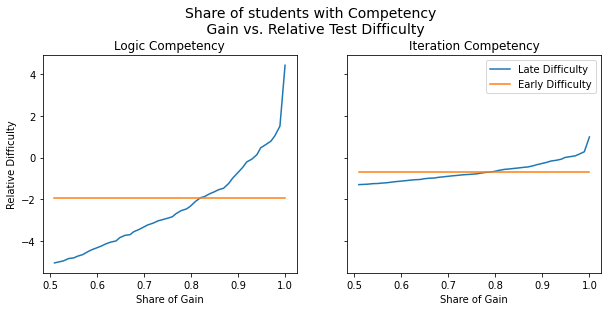

In [54]:
early_reldiff = rel_test_difficulty(A=early_A, delta=early_delta)
shift_table(s_hat=s_hat, A=late_A, delta=late_delta, early_reldiff=early_reldiff)
plt.savefig("results/plots/csedm_reldiff_vs_shift", dpi=200)

In [55]:
shift = np.zeros(2)
#Logic shift
shift[0] = -1*np.quantile(s_hat[:,0], q=0.2, axis=0)
#Iteration shift
shift[1] = -1*np.quantile(s_hat[:,1], q=0.05, axis=0)
s_hat_shift = s_hat + shift
mu_shift = late_model.person_parameters["mean"][2:4] + shift
late_delta_shift = late_delta - np.dot(late_A, shift)

In [56]:
#Check shift results
np.divide(np.sum(s_hat_shift >= 0, axis=0), np.sum(s_hat_shift == s_hat_shift, axis=0))

array([0.79836512, 0.94822888])

In [57]:
def item_parameter_table(A, Q, delta, latent_description=["Logic", "Iteration"], caption="", n=367):
    data = pd.DataFrame(np.concatenate((Q, A), axis=1))
    data.columns = pd.MultiIndex.from_product([['Q', 'A'], latent_description],
                                     names=['Param.', 'Latent dim.'])
    delta_df = pd.DataFrame(np.expand_dims(delta, 1), columns=[("$\Delta$", "")])
    data = pd.concat((data, delta_df), axis=1)
    data = np.round(data, 3)
    print(data.to_latex(bold_rows=True, multicolumn=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(data)

In [58]:
item_parameter_table(A=early_A, Q=early_Q, delta=early_delta, caption="CSEDM: Early Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Early Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   1.0 &       0.0 &  0.901 &     0.000 &    1.716 \\
\textbf{1 } &   1.0 &       0.0 &  1.323 &     0.000 &    1.359 \\
\textbf{2 } &   1.0 &       0.0 &  0.913 &     0.000 &    1.276 \\
\textbf{3 } &   1.0 &       0.0 &  0.838 &     0.000 &    1.345 \\
\textbf{4 } &   1.0 &       0.0 &  1.179 &     0.000 &    1.309 \\
\textbf{5 } &   1.0 &       0.0 &  1.326 &     0.000 &    1.442 \\
\textbf{6 } &   1.0 &       0.0 &  0.951 &     0.000 &    1.140 \\
\textbf{7 } &   1.0 &       0.0 &  0.877 &     0.000 &    1.297 \\
\textbf{8 } &   1.0 &       0.0 &  1.051 &     0.000 &    1.208 \\
\textbf{9 } &   1.0 &       0.0 &  1.305 &     0.000 &    1.235 \\
\textbf{10} &   1.0 &       0.0 &  1.122 &     0.00

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             1.0       0.0  0.901     0.000    1.716
1             1.0       0.0  1.323     0.000    1.359
2             1.0       0.0  0.913     0.000    1.276
3             1.0       0.0  0.838     0.000    1.345
4             1.0       0.0  1.179     0.000    1.309
5             1.0       0.0  1.326     0.000    1.442
6             1.0       0.0  0.951     0.000    1.140
7             1.0       0.0  0.877     0.000    1.297
8             1.0       0.0  1.051     0.000    1.208
9             1.0       0.0  1.305     0.000    1.235
10            1.0       0.0  1.122     0.000    1.487
11            1.0       0.0  1.132     0.000    1.562
12            1.0       0.0  1.228     0.000    1.575
13            1.0       0.0  1.345     0.000    1.474
14            1.0       0.0  1.140     0.000    1.169
15            1.0       0.0  1.179     0.000    0.801
16            1.0       0.0  1.072     0.000    1.153
17            1.0       0.0  0.995     0.000    1.190
18            1.0       1.0  1.000     0.884    0.270
19            1.0       0.0  0.874     0.000    0.609
20            0.0       1.0  0.000     2.496    1.580
21            1.0       1.0  0.068     2.428    1.154
22            1.0       1.0  0.220     1.678    1.173
23            1.0       1.0  0.529     1.731    1.197
24            1.0       1.0  1.056     1.455    1.566
25            1.0       0.0  0.903     0.000    1.075
26            1.0       1.0  0.538     1.419    0.547
27            1.0       1.0  0.869     1.379    1.224
28            1.0       1.0  0.891     0.776    1.036
29            1.0       1.0  0.560     1.668    0.995

In [59]:
item_parameter_table(A=late_A, Q=late_Q, delta=late_delta_shift, caption="CSEDM: Late Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Late Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   0.0 &       1.0 &  0.000 &     0.517 &    0.884 \\
\textbf{1 } &   1.0 &       1.0 &  1.000 &     1.000 &    0.398 \\
\textbf{2 } &   1.0 &       0.0 &  1.262 &     0.000 &    1.575 \\
\textbf{3 } &   1.0 &       1.0 &  0.811 &     1.451 &   -0.083 \\
\textbf{4 } &   1.0 &       1.0 &  1.079 &     0.616 &    0.340 \\
\textbf{5 } &   1.0 &       1.0 &  0.666 &     0.830 &    0.279 \\
\textbf{6 } &   1.0 &       1.0 &  0.661 &     0.836 &    0.172 \\
\textbf{7 } &   1.0 &       1.0 &  0.495 &     1.241 &   -0.100 \\
\textbf{8 } &   1.0 &       1.0 &  0.792 &     2.211 &   -0.728 \\
\textbf{9 } &   1.0 &       1.0 &  0.206 &     1.261 &   -0.553 \\
\textbf{10} &   1.0 &       1.0 &  1.000 &     1.131

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             0.0       1.0  0.000     0.517    0.884
1             1.0       1.0  1.000     1.000    0.398
2             1.0       0.0  1.262     0.000    1.575
3             1.0       1.0  0.811     1.451   -0.083
4             1.0       1.0  1.079     0.616    0.340
5             1.0       1.0  0.666     0.830    0.279
6             1.0       1.0  0.661     0.836    0.172
7             1.0       1.0  0.495     1.241   -0.100
8             1.0       1.0  0.792     2.211   -0.728
9             1.0       1.0  0.206     1.261   -0.553
10            1.0       1.0  1.000     1.131    0.060
11            1.0       1.0  0.352     2.001    0.140
12            1.0       1.0  0.341     1.377   -0.337
13            1.0       1.0  0.382     1.244    0.235
14            0.0       1.0  0.000     1.078    0.948
15            1.0       1.0  0.047     1.918    0.037
16            1.0       1.0  0.629     1.653   -0.965
17            1.0       1.0  0.456     1.098    0.132
18            0.0       1.0  0.000     1.784   -0.136
19            0.0       1.0  0.000     1.498    0.255

(array([[  2.,  18.,  55., 125., 151.,  16.,   0.,   0.,   0.,   0.],
        [  0.,   2.,  17.,  35.,  64.,  86., 119.,  34.,   7.,   3.]]),
 array([-1.08155124, -0.71913464, -0.35671804,  0.00569856,  0.36811515,
         0.73053175,  1.09294835,  1.45536495,  1.81778155,  2.18019814,
         2.54261474]),
 <a list of 2 BarContainer objects>)

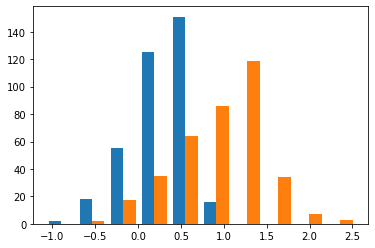

In [60]:
plt.hist(s_hat_shift)

#### Person Parameters

In [61]:
#early
early_covariance = early_model.person_parameters["covariance"]
early_mu = np.zeros(2)

#late
late_covariance = late_model.person_parameters["covariance"]
late_mu = np.concatenate((early_mu, mu_shift), axis=0)

In [62]:
def table_person_parameters(covariance, mu, latent_description=["Logic", "Iteration"], caption="", n=367):
    cov_df = pd.DataFrame(covariance)
    index = pd.MultiIndex.from_product([['Prior Competence', 'Competence Gain'], latent_description],
                        names=['Param.', 'Latent dim.'])
    cov_df.columns = index
    mu_df = pd.DataFrame(np.expand_dims(mu, axis=1), columns=[("Mean", "")])
    person_df = pd.concat((cov_df, mu_df), axis=1)
    person_df.index = index
    person_df = np.round(person_df, 3)
    print(person_df.to_latex(bold_rows=True, multicolumn=True, 
                                caption=caption+", n={0}".format(n), 
                                position="H", escape=False))
    return(person_df)
    

In [63]:
table_person_parameters(covariance=late_covariance, mu=late_mu, caption="CSEDM: Person Parameters")
# TODO: Evtl. Korrelationsmatrix mit Varianz-Spalte

\begin{table}[H]
\centering
\caption{CSEDM: Person Parameters, n=367}
\begin{tabular}{llrrrrr}
\toprule
                & \textbf{Param.} & \multicolumn{2}{l}{Prior Competence} & \multicolumn{2}{l}{Competence Gain} &   Mean \\
                & \textbf{Latent dim.} &            Logic & Iteration &           Logic & \multicolumn{2}{l}{Iteration} \\
\textbf{Param.} & \textbf{Latent dim.} &                  &           &                 &           &        \\
\midrule
\textbf{Prior Competence} & \textbf{Logic} &            1.000 &     0.242 &           0.139 &     0.070 &  0.000 \\
                & \textbf{Iteration} &            0.242 &     1.000 &           0.064 &     0.146 &  0.000 \\
\textbf{Competence Gain} & \textbf{Logic} &            0.139 &     0.064 &           0.357 &     0.090 &  0.239 \\
                & \textbf{Iteration} &            0.070 &     0.146 &           0.090 &     0.346 &  0.913 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1204287124.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(person_df.to_latex(bold_rows=True, multicolumn=True,


Param.                       Prior Competence           Competence Gain  \
Latent dim.                             Logic Iteration           Logic   
Param.           Latent dim.                                              
Prior Competence Logic                  1.000     0.242           0.139   
                 Iteration              0.242     1.000           0.064   
Competence Gain  Logic                  0.139     0.064           0.357   
                 Iteration              0.070     0.146           0.090   

Param.                                   Mean  
Latent dim.                  Iteration         
Param.           Latent dim.                   
Prior Competence Logic           0.070  0.000  
                 Iteration       0.146  0.000  
Competence Gain  Logic           0.090  0.239  
                 Iteration       0.346  0.913

#### Gain Visualization

In [51]:
def quantile_mean(df, metric, quantiles=[0.25, 0.5, 0.75, 1]):
    mean_df = pd.DataFrame()
    metric_quantiles = np.quantile(df[metric], quantiles)
    for quantile in metric_quantiles:
        quantile_df = df[df[metric] < quantile]
        df = df[df[metric] >= quantile]
        mean_df = pd.concat((mean_df, pd.DataFrame(quantile_df.mean()).transpose()), axis=0)
    mean_df.index = quantiles
    return(mean_df)

In [125]:
latent_df_csedm = pd.DataFrame(np.concatenate((theta_hat, s_hat_shift), axis=1))
latent_df_csedm.columns = ["prior logic", "prior iter", "logic gain", "iter gain"]

In [126]:
logic_quantile_mean = quantile_mean(latent_df_csedm, metric="prior logic")
logic_quantile_mean["post logic"] = logic_quantile_mean["prior logic"] + logic_quantile_mean["logic gain"]
logic_quantile_mean["post iter"] = logic_quantile_mean["prior iter"] + logic_quantile_mean["iter gain"]
np.round(logic_quantile_mean, 2)

,prior logic,prior iter,logic gain,iter gain,post logic,post iter
0.25,-0.95,-0.31,0.25,1.06,-0.70,0.75
0.50,-0.20,-0.04,0.18,0.88,-0.02,0.84
0.75,0.34,-0.05,0.20,0.91,0.53,0.86
1.00,1.11,0.44,0.26,0.95,1.37,1.38


In [127]:
logic_quantiles = np.quantile(theta_hat[:,0], [0.25, 0.5, 0.75, 1], axis=0)
iter_quantiles = np.quantile(theta_hat[:,1], [0.25, 0.5, 0.75, 1], axis=0)

In [128]:
theta_logic_quantiles = np.split(theta_hat[np.argsort(theta_hat[:,0]), :], [10, 20])

## Test Set prediction

In [46]:
TEST_PATH = os.path.join("C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset/F19_Release_Test_06-28-21/test")

test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

#test_subject_df = make_subject_df(early_test)
#test_subject_df = test_subject_df.drop("PercAltLabelTrue", 1)

#Obtain Matrix of Response-vectors
test_U = pd.crosstab(index = early_test["SubjectID"], 
            columns=[early_test["AssignmentID"], early_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")